# Melanoma Classification using CNN

This notebook implements a Convolutional Neural Network (CNN) for melanoma detection using processed images.

In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices()}")

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## 1. Load and Prepare Data

We'll load the processed images for melanoma classification.

In [52]:
# Set paths
base_path = '../'
processed_dir = os.path.join(base_path, 'working', 'processed_images')
melanoma_dir = os.path.join(processed_dir, 'melanoma')
non_melanoma_dir = os.path.join(processed_dir, 'non_melanoma')

In [67]:
# # Use Keras generators instead of loading all images into memory
# # Function to load images from directories
# def load_images_from_directory(directory, label):
#     images = []
#     labels = []

#     if not os.path.exists(directory):
#         print(f"Warning: Directory {directory} does not exist!")
#         return images, labels

#     for filename in os.listdir(directory):
#         if filename.endswith('.jpg'):
#             img_path = os.path.join(directory, filename)
#             try:
#                 img = cv2.imread(img_path)
#                 if img is not None:
#                     img = cv2.resize(img, (224, 224))  # Ensure consistent size
#                     images.append(img)
#                     labels.append(label)
#             except Exception as e:
#                 print(f"Error loading {img_path}: {e}")

#     return images, labels


# # Load melanoma and non-melanoma images
# print("Loading melanoma images...")
# melanoma_images, melanoma_labels = load_images_from_directory(melanoma_dir, 1)

# print("Loading non-melanoma images...")
# non_melanoma_images, non_melanoma_labels = load_images_from_directory(
#     non_melanoma_dir, 0)

# # Combine datasets
# X = np.array(melanoma_images + non_melanoma_images[:5000])
# y = np.array(melanoma_labels + non_melanoma_labels)

# # Print dataset information
# print(f"Dataset loaded: {X.shape[0]} images")
# print(f"Melanoma images: {len(melanoma_images)}")
# print(f"Non-melanoma images: {len(non_melanoma_images)}")

# # Technically this should be done in data augmentation and pre-processing but for now we are lazy
# # Reshape and normalize images for CNN input
# X = X.reshape(-1, 224, 224, 3).astype('float32') / 255.0
# Define ImageDataGenerator with augmentation and split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    brightness_range=[0.8,1.2]
)

# Undersample non-melanoma images: sample 6000 while using all melanoma images
from sklearn.model_selection import train_test_split
import glob, random
import pandas as pd

# List image file paths
melanoma_paths = glob.glob(os.path.join(processed_dir, 'melanoma', '*.jpg'))
non_melanoma_paths = glob.glob(os.path.join(processed_dir, 'non_melanoma', '*.jpg'))
random.seed(42)
non_melanoma_sample = random.sample(non_melanoma_paths, min(6000, len(non_melanoma_paths)))

# Build DataFrame for Keras generator
df = pd.DataFrame({
    'filename': melanoma_paths + non_melanoma_sample,
    'class': ['melanoma'] * len(melanoma_paths) + ['non_melanoma'] * len(non_melanoma_sample)
})

# Split into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['class'], random_state=42)

# Create generators from DataFrame
train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col='filename', y_col='class',
    target_size=(224, 224), color_mode='rgb',
    batch_size=32, class_mode='binary',
    shuffle=True, seed=42
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col='filename', y_col='class',
    target_size=(224, 224), color_mode='rgb',
    batch_size=32, class_mode='binary',
    shuffle=False, seed=42
)

Found 8417 validated image filenames belonging to 2 classes.
Found 2105 validated image filenames belonging to 2 classes.
Found 2105 validated image filenames belonging to 2 classes.


In [ ]:
import albumentations as A
import random
from sklearn.utils import shuffle

# Balancing the data set with the same number of melanoma samples since we'll augment them
target_samples = 4522

print(f"Original dataset - Melanoma: {len(melanoma_images)}, Non-melanoma: {len(non_melanoma_images)}")

# # 1. Subsample non-melanoma images to reduce class imbalance
# non_melanoma_indices = list(range(len(non_melanoma_images)))
# random.seed(42)
# random.shuffle(non_melanoma_indices)
# non_melanoma_indices = non_melanoma_indices[:target_samples]
# non_melanoma_images_balanced = [non_melanoma_images[i] for i in non_melanoma_indices]
# non_melanoma_labels_balanced = [non_melanoma_labels[i] for i in non_melanoma_indices]

# print(f"After subsampling - Non-melanoma: {len(non_melanoma_images_balanced)}")

# # 2. Create augmentation pipeline
# augmentation = A.Compose([
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.RandomRotate90(p=0.5),
#     A.RandomBrightnessContrast(p=0.5),
#     A.Rotate(limit=30, p=0.5),
#     A.GaussianBlur(blur_limit=(3, 7), p=0.3),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=45, p=0.5),
#     A.GridDistortion(p=0.3),
#     A.ElasticTransform(p=0.3),
# ])

# melanoma_images_augmented = melanoma_images.copy()
# melanoma_labels_augmented = melanoma_labels.copy()

# print("Augmenting melanoma images...")

# # Generate augmented images for the melanoma class to balance dataset
# num_augmentations_needed = target_samples - len(melanoma_images)
# images_to_augment = random.choices(melanoma_images, k=num_augmentations_needed)

# for img in images_to_augment:
#     img_uint8 = img.astype(np.uint8)
#     augmented = augmentation(image=img_uint8)
#     melanoma_images_augmented.append(augmented['image'])
#     melanoma_labels_augmented.append(1)

# print(f"After augmentation - Melanoma: {len(melanoma_images_augmented)}")

# Create balanced dataset
X_balanced = np.array(melanoma_images + non_melanoma_images[:target_samples])
y_balanced = np.array(melanoma_labels + non_melanoma_labels[:target_samples])

# Shuffle the data
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=42)

# Reshape and normalize images for CNN input
X_balanced = X_balanced.reshape(-1, 224, 224, 1).astype('float32') / 255.0

print(f"Balanced dataset - Total: {X_balanced.shape[0]} images")
print(f"Class distribution - Melanoma: {np.sum(y_balanced == 1)}, Non-melanoma: {np.sum(y_balanced == 0)}")

# Replace original X and y with balanced dataset
X, y = X_balanced, y_balanced


Original dataset - Melanoma: 4522, Non-melanoma: 20809
Balanced dataset - Total: 9044 images
Class distribution - Melanoma: 4522, Non-melanoma: 4522


In [63]:
# Split data into training, validation, and test sets
# First split: 80% training+validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: 80% training, 20% validation (from the training+validation set)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Check class distribution in each set
print(f"Training set - Melanoma: {np.sum(y_train == 1)}, Non-melanoma: {np.sum(y_train == 0)}")
print(f"Validation set - Melanoma: {np.sum(y_val == 1)}, Non-melanoma: {np.sum(y_val == 0)}")
print(f"Test set - Melanoma: {np.sum(y_test == 1)}, Non-melanoma: {np.sum(y_test == 0)}")

ValueError: Found input variables with inconsistent numbers of samples: [9044, 25331]

## 2. Build CNN Model

We'll create a CNN model architecture suitable for melanoma classification.

In [64]:
# Replace model builder with new binary classification CNN
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_melanoma_cnn(input_shape=(224, 224, 3), num_classes=2):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(3, 3), strides=(1, 1)),
        Conv2D(64, (5, 5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(1, 1)),
        Flatten(),
        Dense(38, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid'),  # binary output
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# Build the model using new architecture
model = build_melanoma_cnn()
model.summary()

c:\Users\Priya\Downloads\kaggle\melanoma-project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 222, 222, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 220, 220, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3097600)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 38)             │   117,708,838 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 38)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,761,037 (449.22 MB)

 Trainable params: 117,761,037 (449.22 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Set up callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    ModelCheckpoint('../working/melanoma_model.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
]

# Calculate class weights to handle imbalance
class_weight = {
    0: 1.0,
    1: len(y_train[y_train == 0]) / len(y_train[y_train == 1]) if np.sum(y_train == 1) > 0 else 1.0
}
print(f"Class weights: {class_weight}")

Class weights: {0: 1.0, 1: 1.0}


In [69]:
# Train the model using generators
batch_size = 32
epochs = 20

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

c:\Users\Priya\Downloads\kaggle\melanoma-project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5891 - auc: 0.6076 - loss: 1.2929
Epoch 1: val_auc improved from -inf to 0.75841, saving model to ../working/melanoma_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 1188s 4s/step - accuracy: 0.5892 - auc: 0.6078 - loss: 1.2909 - val_accuracy: 0.6888 - val_auc: 0.7584 - val_loss: 0.5849 - learning_rate: 1.0000e-04
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6459 - auc: 0.7010 - loss: 0.6119
Epoch 2: val_auc improved from 0.75841 to 0.78652, saving model to ../working/melanoma_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 1219s 5s/step - accuracy: 0.6460 - auc: 0.7010 - loss: 0.6118 - val_accuracy: 0.6969 - val_auc: 0.7865 - val_loss: 0.5581 - learning_rate: 1.0000e-04
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6638 - auc: 0.7330 - loss: 0.5900
Epoch 3: val_auc did not improve from 0.78652
264/264 ━━━━━━━━━━━━━━━━━━━━ 766s 3s/step - accuracy: 0.6638 - auc: 0.7330 - loss: 0.5900 - val_accuracy: 0.6941 - val_auc: 0.7781 - val_loss: 0.5618 - learning_rate: 1.0000e-04
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6906 - auc: 0.7560 - loss: 0.5691
Epoch 4: val_auc did not improve from 0.78652
264/264 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - accuracy: 0.6906 - auc: 0.7559 - loss: 0.5692 - val_accuracy: 0.6599 - val_auc: 0.6889 - val_loss: 0.6278 - learning_rate: 1.0000e-04
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6647 - auc: 0.7229 - loss: 0.5981
Epoch 5: val_auc improved from 0.78652 to 0.80689, saving model to ../workin

264/264 ━━━━━━━━━━━━━━━━━━━━ 495s 2s/step - accuracy: 0.6647 - auc: 0.7230 - loss: 0.5981 - val_accuracy: 0.7259 - val_auc: 0.8069 - val_loss: 0.5459 - learning_rate: 1.0000e-04
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6802 - auc: 0.7535 - loss: 0.5725
Epoch 6: val_auc did not improve from 0.80689
264/264 ━━━━━━━━━━━━━━━━━━━━ 818s 3s/step - accuracy: 0.6802 - auc: 0.7536 - loss: 0.5725 - val_accuracy: 0.7131 - val_auc: 0.7950 - val_loss: 0.5419 - learning_rate: 1.0000e-04
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6913 - auc: 0.7659 - loss: 0.5635
Epoch 7: val_auc improved from 0.80689 to 0.80973, saving model to ../working/melanoma_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 805s 3s/step - accuracy: 0.6914 - auc: 0.7659 - loss: 0.5635 - val_accuracy: 0.7221 - val_auc: 0.8097 - val_loss: 0.5258 - learning_rate: 1.0000e-04
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7069 - auc: 0.7800 - loss: 0.5453
Epoch 8: val_auc did not improve from 0.80973
264/264 ━━━━━━━━━━━━━━━━━━━━ 597s 2s/step - accuracy: 0.7068 - auc: 0.7800 - loss: 0.5454 - val_accuracy: 0.7211 - val_auc: 0.8094 - val_loss: 0.5188 - learning_rate: 1.0000e-04
Epoch 9/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7073 - auc: 0.7820 - loss: 0.5498
Epoch 9: val_auc did not improve from 0.80973
264/264 ━━━━━━━━━━━━━━━━━━━━ 643s 2s/step - accuracy: 0.7073 - auc: 0.7819 - loss: 0.5498 - val_accuracy: 0.7164 - val_auc: 0.8047 - val_loss: 0.5399 - learning_rate: 1.0000e-04
Epoch 10/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6986 - auc: 0.7766 - loss: 0.5539
Epoch 10: val_auc did not improve from 0.80973
264/264 ━━━━━━━━━━━━━━━━━━━━ 

In [72]:
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weight,
    verbose=1
)

Epoch 1/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7055 - auc: 0.7827 - loss: 0.5396
Epoch 1: val_auc improved from 0.80973 to 0.81506, saving model to ../working/melanoma_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - accuracy: 0.7056 - auc: 0.7827 - loss: 0.5396 - val_accuracy: 0.7311 - val_auc: 0.8151 - val_loss: 0.5156 - learning_rate: 2.0000e-05
Epoch 2/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7108 - auc: 0.7904 - loss: 0.5376
Epoch 2: val_auc improved from 0.81506 to 0.81575, saving model to ../working/melanoma_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 462s 2s/step - accuracy: 0.7108 - auc: 0.7904 - loss: 0.5376 - val_accuracy: 0.7249 - val_auc: 0.8158 - val_loss: 0.5109 - learning_rate: 2.0000e-05
Epoch 3/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7134 - auc: 0.7937 - loss: 0.5316
Epoch 3: val_auc improved from 0.81575 to 0.81643, saving model to ../working/melanoma_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.7134 - auc: 0.7937 - loss: 0.5316 - val_accuracy: 0.7349 - val_auc: 0.8164 - val_loss: 0.5110 - learning_rate: 2.0000e-05
Epoch 4/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7189 - auc: 0.8009 - loss: 0.5281
Epoch 4: val_auc improved from 0.81643 to 0.82094, saving model to ../working/melanoma_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.7188 - auc: 0.8009 - loss: 0.5282 - val_accuracy: 0.7382 - val_auc: 0.8209 - val_loss: 0.5146 - learning_rate: 2.0000e-05
Epoch 5/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7127 - auc: 0.7999 - loss: 0.5248
Epoch 5: val_auc improved from 0.82094 to 0.82267, saving model to ../working/melanoma_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.7127 - auc: 0.7998 - loss: 0.5249 - val_accuracy: 0.7392 - val_auc: 0.8227 - val_loss: 0.5106 - learning_rate: 2.0000e-05
Epoch 6/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7093 - auc: 0.7929 - loss: 0.5382
Epoch 6: val_auc did not improve from 0.82267
264/264 ━━━━━━━━━━━━━━━━━━━━ 437s 2s/step - accuracy: 0.7093 - auc: 0.7929 - loss: 0.5382 - val_accuracy: 0.7325 - val_auc: 0.8148 - val_loss: 0.5126 - learning_rate: 2.0000e-05
Epoch 7/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7145 - auc: 0.7958 - loss: 0.5299
Epoch 7: val_auc did not improve from 0.82267
264/264 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.7145 - auc: 0.7958 - loss: 0.5299 - val_accuracy: 0.7254 - val_auc: 0.8133 - val_loss: 0.5144 - learning_rate: 2.0000e-05
Epoch 8/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7171 - auc: 0.7897 - loss: 0.5346
Epoch 8: val_auc did not improve from 0.82267
264/264 ━━━━━━━━━━━━━━━━━━━━ 44

264/264 ━━━━━━━━━━━━━━━━━━━━ 967s 4s/step - accuracy: 0.7282 - auc: 0.8104 - loss: 0.5139 - val_accuracy: 0.7458 - val_auc: 0.8232 - val_loss: 0.5110 - learning_rate: 2.0000e-05
Epoch 13/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 115s/step - accuracy: 0.7210 - auc: 0.8005 - loss: 0.5273  
Epoch 13: val_auc did not improve from 0.82318
264/264 ━━━━━━━━━━━━━━━━━━━━ 30317s 115s/step - accuracy: 0.7210 - auc: 0.8005 - loss: 0.5273 - val_accuracy: 0.7245 - val_auc: 0.8152 - val_loss: 0.5098 - learning_rate: 2.0000e-05
Epoch 14/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7207 - auc: 0.8032 - loss: 0.5191
Epoch 14: val_auc improved from 0.82318 to 0.82463, saving model to ../working/melanoma_model.h5


264/264 ━━━━━━━━━━━━━━━━━━━━ 1392s 5s/step - accuracy: 0.7207 - auc: 0.8032 - loss: 0.5191 - val_accuracy: 0.7411 - val_auc: 0.8246 - val_loss: 0.5037 - learning_rate: 2.0000e-05
Epoch 15/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7196 - auc: 0.7986 - loss: 0.5241
Epoch 15: val_auc did not improve from 0.82463
264/264 ━━━━━━━━━━━━━━━━━━━━ 709s 3s/step - accuracy: 0.7196 - auc: 0.7986 - loss: 0.5241 - val_accuracy: 0.7406 - val_auc: 0.8235 - val_loss: 0.5032 - learning_rate: 2.0000e-05
Epoch 16/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7163 - auc: 0.7971 - loss: 0.5271
Epoch 16: val_auc did not improve from 0.82463
264/264 ━━━━━━━━━━━━━━━━━━━━ 686s 3s/step - accuracy: 0.7163 - auc: 0.7972 - loss: 0.5271 - val_accuracy: 0.7373 - val_auc: 0.8235 - val_loss: 0.5039 - learning_rate: 2.0000e-05
Epoch 17/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7223 - auc: 0.7982 - loss: 0.5242
Epoch 17: val_auc did not improve from 0.82463
264/264 ━━━━━━━━━━━━━━━━

264/264 ━━━━━━━━━━━━━━━━━━━━ 2846s 11s/step - accuracy: 0.7294 - auc: 0.8094 - loss: 0.5136 - val_accuracy: 0.7458 - val_auc: 0.8290 - val_loss: 0.4987 - learning_rate: 2.0000e-05
Epoch 20/20
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7279 - auc: 0.8093 - loss: 0.5147
Epoch 20: val_auc did not improve from 0.82896
264/264 ━━━━━━━━━━━━━━━━━━━━ 524s 2s/step - accuracy: 0.7279 - auc: 0.8093 - loss: 0.5147 - val_accuracy: 0.7321 - val_auc: 0.8202 - val_loss: 0.5053 - learning_rate: 2.0000e-05


## 3. Evaluate Model Performance

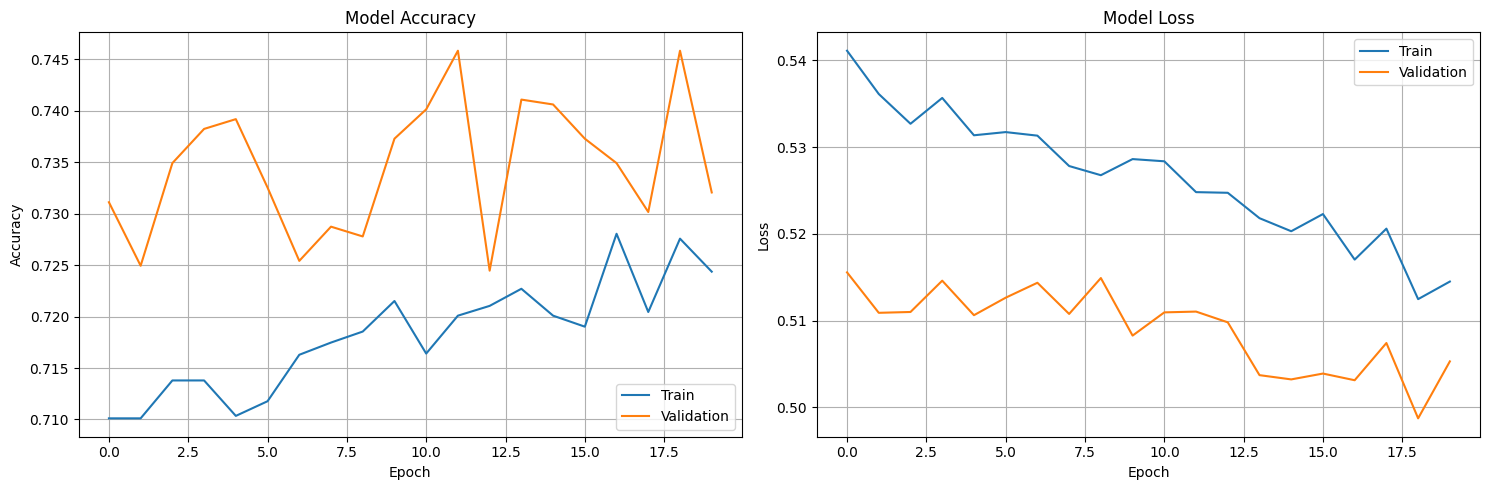

In [73]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='lower right')
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

In [ ]:
# Evaluate on test set using generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    processed_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_loss, test_acc, test_auc = model.evaluate(test_gen)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Make predictions on test set
y_pred_proba = model.predict(test_gen)

y_true = test_gen.classes
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Non-Melanoma', 'Melanoma']))

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

Found 25331 images belonging to 2 classes.


c:\Users\Priya\Downloads\kaggle\melanoma-project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


792/792 ━━━━━━━━━━━━━━━━━━━━ 370s 466ms/step - accuracy: 0.7247 - auc: 0.6866 - loss: 0.5064
Test accuracy: 0.7826
Test AUC: 0.8181
792/792 ━━━━━━━━━━━━━━━━━━━━ 334s 422ms/step

Classification Report:
              precision    recall  f1-score   support

Non-Melanoma       0.43      0.63      0.51      4522
    Melanoma       0.91      0.82      0.86     20809

    accuracy                           0.78     25331
   macro avg       0.67      0.72      0.68     25331
weighted avg       0.82      0.78      0.80     25331


Confusion Matrix:
[[ 2842  1680]
 [ 3826 16983]]


In [78]:
print(classification_report(y_true, y_pred, target_names=['Melenoma', 'Non-Melanoma']))

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

              precision    recall  f1-score   support

    Melenoma       0.43      0.63      0.51      4522
Non-Melanoma       0.91      0.82      0.86     20809

    accuracy                           0.78     25331
   macro avg       0.67      0.72      0.68     25331
weighted avg       0.82      0.78      0.80     25331


Confusion Matrix:
[[ 2842  1680]
 [ 3826 16983]]


In [74]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

NameError: name 'y_true' is not defined

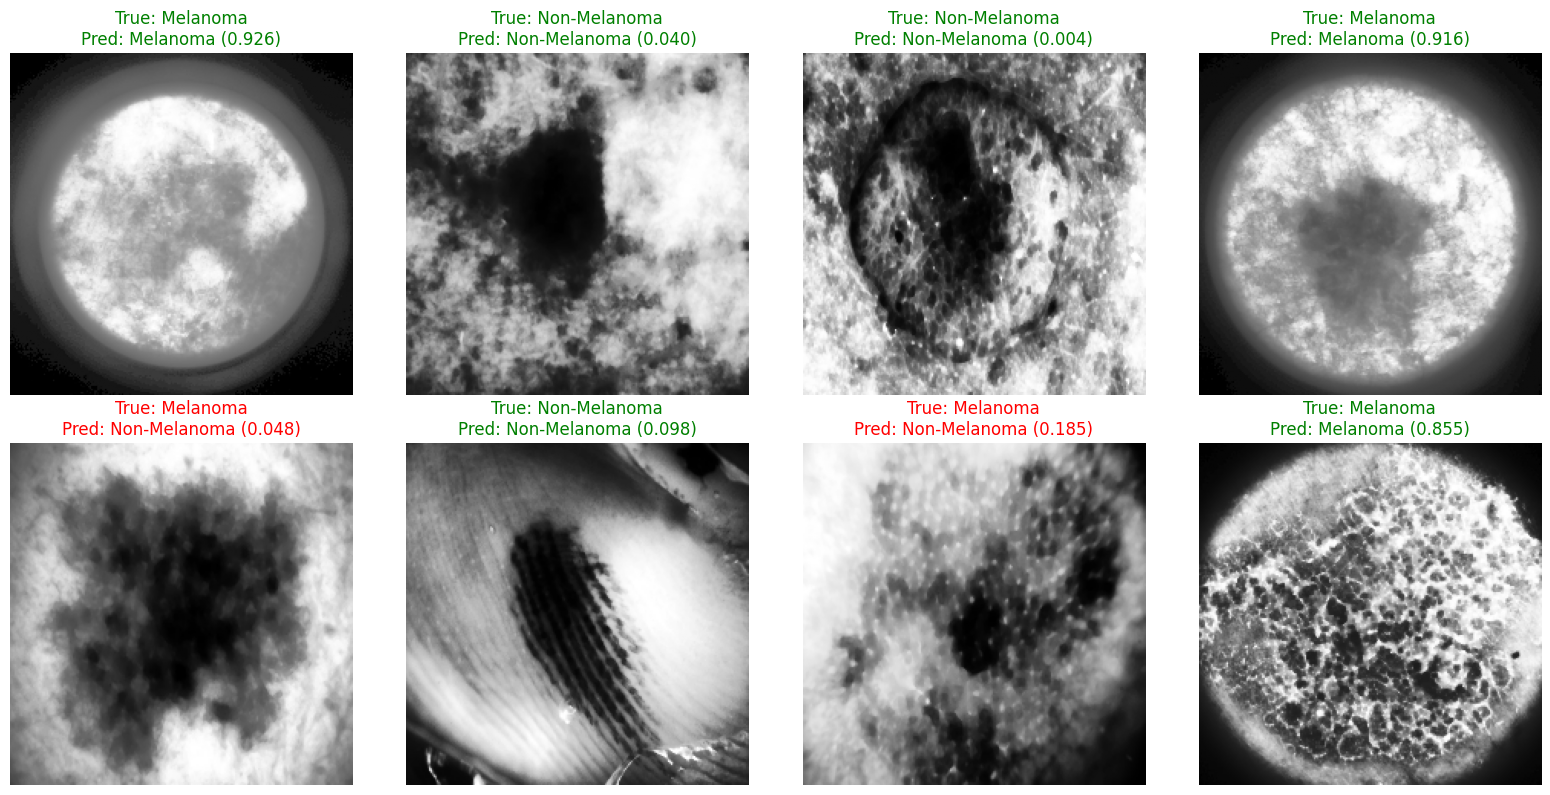

In [ ]:
# Visualize some predictions
def visualize_predictions(X, y_true, y_pred, y_pred_proba, num_samples=8):
    # Select random samples
    indices = np.random.choice(range(len(y_true)), min(num_samples, len(y_true)), replace=False)
    
    # Create figure
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        if i >= num_samples:
            break
            
        # Get image and labels
        img = X[idx].reshape(224, 224)
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        prob = y_pred_proba[idx][0]
        
        # Determine text color based on prediction correctness
        color = 'green' if true_label == pred_label else 'red'
        
        # Plot image
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"True: {'Melanoma' if true_label == 1 else 'Non-Melanoma'}\n" +
                        f"Pred: {'Melanoma' if pred_label == 1 else 'Non-Melanoma'} ({prob:.3f})",
                        color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(X_test, y_test, y_pred, y_pred_proba)

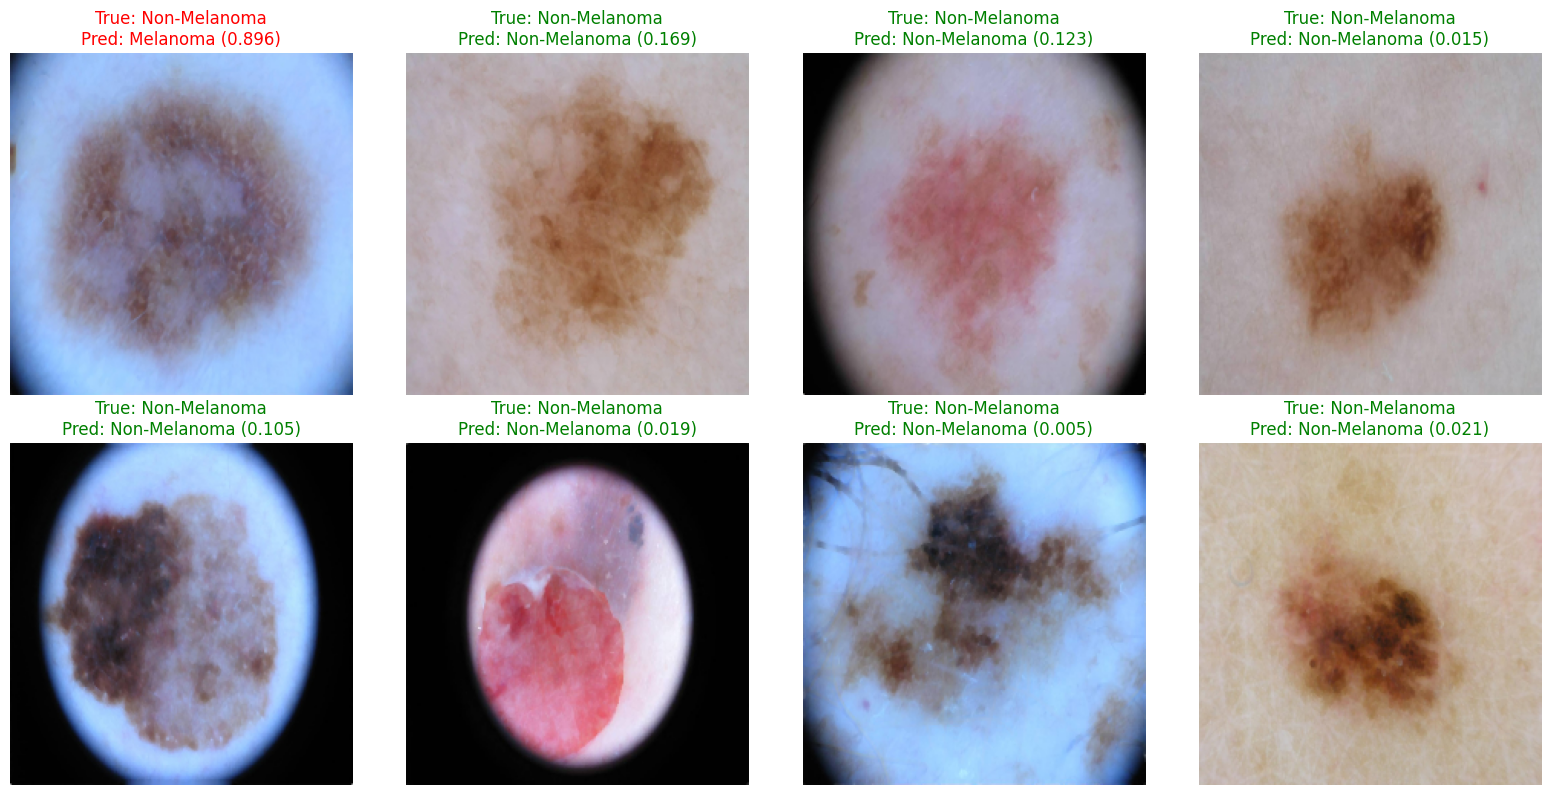

In [75]:
# Visualize predictions from test generator
def visualize_generator_predictions(generator, y_pred, y_pred_proba, num_samples=8):
    images, labels = next(generator)
    preds = (y_pred[:len(labels)]).astype(int)
    probs = y_pred_proba[:len(labels)]
    
    # Select random samples
    indices = np.random.choice(range(len(labels)), min(num_samples, len(labels)), replace=False)
    
    # Plot samples
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    for i, idx in enumerate(indices):
        if i >= len(indices):
            break
        img = images[idx]
        true_label = labels[idx]
        pred_label = preds[idx]
        prob = probs[idx][0] if probs.ndim > 1 else probs[idx]
        color = 'green' if true_label == pred_label else 'red'
        axes[i].imshow(img)
        axes[i].set_title(
            f"True: {'Melanoma' if true_label == 1 else 'Non-Melanoma'}\n" +
            f"Pred: {'Melanoma' if pred_label == 1 else 'Non-Melanoma'} ({prob:.3f})",
            color=color
        )
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Run visualization
enum_gen = test_gen  # ensure test_gen is reset if needed
visualize_generator_predictions(test_gen, y_pred, y_pred_proba)

## 4. Save Model and Results

In [ ]:
# Save model
model_path = '../working/melanoma_cnn_final_8.h5'
model.save(model_path)
print(f"Model saved to {model_path}")

# Save test results
results = {
    'accuracy': float(test_acc),
    'auc': float(test_auc),
    'loss': float(test_loss)
}

import json
with open('../working/model_results.json', 'w') as f:
    json.dump(results, f)
print("Results saved to ../working/model_results.json")

Model saved to ../working/melanoma_cnn_final_7.h5
Results saved to ../working/model_results.json
